(section:scalar/forward-pass)=
# The forward pass

Now that we understand how to work with computational graphs in `mlfz`, it's time to pull back the curtain and see how they work on the inside. After all, this is what we're here for. (At least, it's why I'm writing this.)

As we've seen it before, `Scalar` implements a node in a computational graph. Thus, it must keep track of three attributes:
* a numeric value,
* the backwards gradient,
* and the list of incoming edges.

This notebook progressively implements the `Scalar` class via adding more and more features. Note that most of the versions here won't have the full functionality of `mlfz.nn.scalar.Scalar`. The full source can be found on [GitHub](https://github.com/cosmic-cortex/mlfz/blob/main/mlfz/nn/scalar/core.py), but the Python code is not exactly a linear front-to-back text, so we'll unravel it one feature at a time.

Here we go:

In [1]:
from typing import List


class Scalar:
    def __init__(self, value: float, prevs: List = None):
        self.value = value
        self.prevs = prevs if prevs is not None else []
        self.backwards_grad = 0

    def __repr__(self):
        return f"Scalar({self.value})"

(I have also added a simple string representation for readability.) Now, we add the meat to the bones. The first thing to do: build the computational graph via operations.

## Building the graph

We are already familiar with the `Scalar` interface: {ref}`the computational graph is built via appling operations and functions <chapter:scalar>`.

In [2]:
from mlfz.nn.scalar import Scalar as Scalar_final

x = Scalar_final(1)
y = Scalar_final(2)

x + y

Scalar(3)

(To avoid confusion, `mlfz.nn.scalar.Scalar` is imported as `Scalar_final`.)

How is this done? By overloading the operations via implementing the magic methods. In the object oriented Python, there are several of them:

* addition `a + b` is done via `__add__`,
* subtraction `a - b` is via `__sub__`,
* negation `-a` is via `__neg__`,
* multiplication `a * b` via `__mul__`,
* division `a / b` via `__truediv__`,
* exponentiation `a ** b` via `__pow__`,

and many more. I'll do the `__add__`, you'll do the rest in an exercise. We'll code first, discuss later.

In [3]:
class Scalar(Scalar):
    # ...

    def __add__(self, other):
        return Scalar(
            value=self.value + other.value,
            prevs=[self, other],
        )
    
    # ...

````{prf:remark} Implementing classes, one method at a time.

As this book is written in Jupyter Notebooks, we can iteratively define classes method by method. To avoid writing out the all the previously implemented methods each time we add a new one, we inherit the new `Scalar` class from the old one. Keep this in mind, as I'll use this trick later.
````

The `__add__` method simply initializes a new `Scalar` instance, formed from the operands. (In this case, `self` and `other`.)

In [4]:
x = Scalar(1)
y = Scalar(2.5)
z = x + y

In [5]:
z.value

3.5

Now, we have a way to track the nodes preceeding `z`:

In [6]:
z.prevs

[Scalar(1), Scalar(2.5)]

Can you implement the rest or the operations? Give them a go before revealing the answer.

In [7]:
class Scalar(Scalar):
    # ...

    def __add__(self, other):
        return Scalar(
            value=self.value + other.value,
            prevs=[self, other],
        )
    
    # implement these methods along the lines of __add__:
    def __mul__(self, other):
        pass

    def __truediv__(self, other):
        pass

    def __pow__(self, exponent):
        pass

    def __neg__(self):
        pass

    def __sub__(self, other):
        pass

    # ...

Here's the solution:

In [8]:
class Scalar(Scalar):
    def __mul__(self, other):
        return Scalar(
            value=self.value * other.value,
            prevs=[self, other],
        )

    def __truediv__(self, other):
        return Scalar(
            value=self.value / other.value,
            prevs=[self, other],
        )

    def __pow__(self, exponent):
        return Scalar(
            value=self.value ** exponent.value,
            prevs=[self, exponent],
        )
    
    def __neg__(self):
        return Scalar(
            value=-self.value,
            prevs=[self],
        )
    
    def __sub__(self, other):
        return self + (-other)

Testing:

In [9]:
x = Scalar(2)
y = Scalar(3)

print(f"{x} + {y} = {x + y}")
print(f"{x} * {y} = {x * y}")
print(f"{x} / {y} = {x / y}")
print(f"{x} ** {y} = {x ** y}")
print(f"{x} - {y} = {x - y}")
print(f"-{x} = {-x}")

Scalar(2) + Scalar(3) = Scalar(5)
Scalar(2) * Scalar(3) = Scalar(6)
Scalar(2) / Scalar(3) = Scalar(0.6666666666666666)
Scalar(2) ** Scalar(3) = Scalar(8)
Scalar(2) - Scalar(3) = Scalar(-1)
-Scalar(2) = Scalar(-2)


### Interoperability with Python's number types

At its current state, operations with Python's number types are not supported. Check this out:

In [10]:
Scalar(1) + 2

AttributeError: 'int' object has no attribute 'value'

The source of this `AttributeError` is that the expression `Scalar(1) + 2` calls `Scalar.__add__`, with arguments `Scalar(1)` and `2`. As `2` is not a `Scalar` object, we immediately run upon an issue.

How can we solve this? One simple way is to check the `Scalar`-ness of the second operand, and make the appropriate conversions if needed.

In [11]:
class Scalar(Scalar):
    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[self, other],
        )
    
    def __mul__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)
    
        return Scalar(
            value=self.value * other.value,
            prevs=[self, other],
        )
    
    # ...
    # the other operations are fixed similarly
    # ...

Does it work?

In [12]:
Scalar(1) + 2

Scalar(3)

Yes, it does!

### Operations left and right

Now that we've enabled operations with vanilla Python number types, can you guess the output of the expression `2 + Scalar(1)`?

Check this out.

In [13]:
2 + Scalar(1)

TypeError: unsupported operand type(s) for +: 'int' and 'Scalar'

What happened?

In Python, the expression `a + b` is equivalent to the function call `a.__add__(b)`. In our case, the left operand is a number, and its `__add__` method doesn't support `Scalar`s. However, there's another magic method called `__radd__`, implementing the addition from the left side. 

What does that mean? That Python falls back to `__radd__` whenever `__add__` doesn't work. To be precise, whenever you call `a + b`,
* `a.__add__(b)` is called,
* and if it fails, Python attempts to call `b.__radd__(a)`,
* and if it fails as well, a `TypeError` is thrown. 

So, let's add `__radd__`.

In [14]:
class Scalar(Scalar):
    def __add__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return Scalar(
            value=self.value + other.value,
            prevs=[self, other],
        )
    
    def __radd__(self, other):
        return self.__add__(other)

    # ...

Does it work?

In [15]:
2 + Scalar(1)

Scalar(3)

Again, it does!

There are magic methods corresponding to the other operations as well:
* `__rmul__`,
* `__rtruediv__`,
* and `__rsub__`.

Can you implement them as an exercise?

In [16]:
class Scalar(Scalar):
    def __neg__(self):
        return (-1) * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    # implement these methods along the lines of __radd__:
    def __rmul__(self, other):
        pass

    def __rtruediv__(self, other):
        pass

    def __rsub__(self, other):
        pass


Here's the solution:

In [17]:
class Scalar(Scalar):    
    def __neg__(self):
        return (-1) * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other):
        if not isinstance(other, Scalar):
            other = Scalar(other)

        return other / self

    def __rsub__(self, other):
        return other + (-self)

Testing:

In [18]:
x = 2
y = Scalar(3)

print(f"{x} + {y} = {x + y}")
print(f"{x} * {y} = {x * y}")
print(f"{x} / {y} = {x / y}")
print(f"{x} - {y} = {x - y}")

2 + Scalar(3) = Scalar(5)
2 * Scalar(3) = Scalar(6)
2 / Scalar(3) = Scalar(0.6666666666666666)
2 - Scalar(3) = Scalar(-1)


(section:computational-graphs/forward-pass/functions)=
### Defining functions for nodes

So far, we've only added support for arithmetic operations such as `+`, `-`, `*`, `/`, and `**`. What about functions? After all, machine learning models are defined by mathematical expressions such as $ f(x) = \sigma(ax + b) $, where

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

is the sigmoid function. How to do that with `Scalar` instances?

There are multiple potential approaches; we'll go with functions that take and return `Scalar` objects. This is simpler than you think. Here we go:

In [19]:
import math


def exp(x: Scalar) -> Scalar:
    return Scalar(
        value=math.exp(x.value),
        prevs=[x]
    )

In [20]:
x = Scalar(2)
y = exp(x)

y

Scalar(7.38905609893065)

In [21]:
y.prevs

[Scalar(2)]

In `mlfz`, these can be found at `mlfz.nn.scalar.functional`. Nothing fancy, just plain old `sin`, `cos`, `sigmoid`, `relu`, and other machine learning-related functions.

Exercise time! Your job is to implement the sigmoid function below.

In [22]:
def sigmoid(x: Scalar) -> Scalar:
    pass

And the solution is:

In [23]:
def sigmoid(x: Scalar) -> Scalar:
    return Scalar(
        value=1 / (1 + math.exp(-x.value)),
        prevs=[x]
    )

This works as expected.

In [24]:
sigmoid(Scalar(3))

Scalar(0.9525741268224334)

## The forward pass

Let's put all of this together and check how the computational graph is built upon applying the operations.

For that, we need a function that recursively traverses all parent nodes and returns the directed graph, using the `Digraph` object from the `graphviz` library.

In [25]:
from graphviz import Digraph


def get_digraph(x):
    digraph = Digraph()

    def register_node(x):
        digraph.node(str(id(x)), f"{x.value: 0.4g}")
        for prev in x.prevs:
            digraph.edges([(str(id(prev)), str(id(x)))])
            register_node(prev)

    register_node(x)

    return digraph

We'll study the simple computational graph defined by

$$
\sigma(a x + b) + a,
$$

where $ \sigma(x) = 1/(1 + e^{-x}) $ is the familiar sigmoid function.

In [26]:
a = Scalar(0.2)
b = Scalar(-1.8)
x = Scalar(0.6)

y = a * x + b
s = sigmoid(y)
z = s + a

(The above is equivalent to the expression `sigmoid(a * x + b) + a`, but I choose to break it up into smaller components to assign variables to all intermediate results.)

First, `y = a * x + b` is computed.

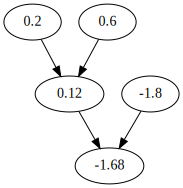

In [27]:
get_digraph(y)

The second step is the application of the sigmoid function, adding a child node to `y`.

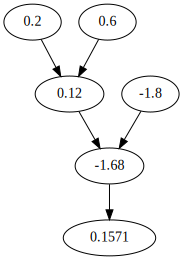

In [28]:
get_digraph(s)

To make things more exciting, we add another node, but this time, we attach it to `s = sigmoid(y)` and the input node `a = Scalar(0.2)`.

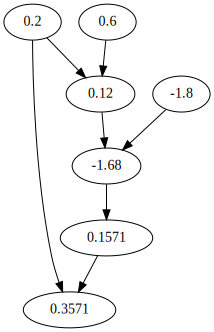

In [29]:
get_digraph(z)

What we've seen here is the forward pass corresponding to the computational graph of `sigmoid(a * x + b) + a`: the input nodes `a`, `b`, and `x` are propagated through the graph to calculate the value `z = sigmoid(a * x + b) + a`, one step at a time.

To train neural networks, we utilize the gradient algorithm that, in turn, requires us to compute the derivative of the final node with respect to all other nodes. This is done in the *backward pass*, and we'll learn what it is in the next chapter.